In [1]:

from dotenv import load_dotenv
load_dotenv()
import os
os.environ['GROQ_API_KEY'] = os.getenv("GROQ_API_KEY")

In [2]:
model="deepseek-r1-distill-llama-70b"

### Load the Model

In [3]:
model="deepseek-r1-distill-llama-70b"
from langchain_groq import ChatGroq
llm=ChatGroq(model_name=model)
llm.invoke("hi")

AIMessage(content='<think>\n\n</think>\n\nHello! How can I assist you today?', additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 14, 'prompt_tokens': 4, 'total_tokens': 18, 'completion_time': 0.070609756, 'prompt_time': 5.5479e-05, 'queue_time': 0.205900835, 'total_time': 0.070665235}, 'model_name': 'deepseek-r1-distill-llama-70b', 'system_fingerprint': 'fp_76307ac09b', 'finish_reason': 'stop', 'logprobs': None}, id='run--5462bcf7-78ca-4671-8f46-eeef2d9dd021-0', usage_metadata={'input_tokens': 4, 'output_tokens': 14, 'total_tokens': 18})

In [4]:
print(llm.invoke("hi").content)

<think>

</think>

Hello! How can I assist you today? 😊


In [5]:
from langchain_core.tools import tool
from langchain_core.messages import HumanMessage, AIMessage
from langgraph.graph import StateGraph,MessagesState,START,END
from langgraph.prebuilt import ToolNode

In [39]:
def call_model(state: MessagesState):
    message = state["messages"]
    response = llm.invoke(message)

    return {"messages": [response]}

In [40]:
state = {"messages": ["Hi, How are you?"]}

call_model(state)

{'messages': [AIMessage(content="<think>\n\n</think>\n\nHi! I'm just a virtual assistant, so I don't have feelings, but I'm here and ready to help you with whatever you need. How are you doing? 😊", additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 42, 'prompt_tokens': 9, 'total_tokens': 51, 'completion_time': 0.216766614, 'prompt_time': 0.000194649, 'queue_time': 0.20608226200000002, 'total_time': 0.216961263}, 'model_name': 'deepseek-r1-distill-llama-70b', 'system_fingerprint': 'fp_76307ac09b', 'finish_reason': 'stop', 'logprobs': None}, id='run--81828a20-af0d-4c81-9601-0f4b6318913e-0', usage_metadata={'input_tokens': 9, 'output_tokens': 42, 'total_tokens': 51})]}

### Design a simple workflow without tool calling

In [43]:
# def call_model(state: MessagesState):
#     question = state["messages"][-1]
#     message = HumanMessage([question])

#     print("This is my Human Message going to LLM ", message)

#     response = llm.invoke(message)

#     return {"messages": [response]}

In [44]:
workflow = StateGraph(MessagesState)

In [45]:
workflow.add_node("mybot", call_model)

In [46]:
workflow.add_edge(START, "mybot")

In [47]:
workflow.add_edge("mybot", END)

In [48]:
app = workflow.compile()

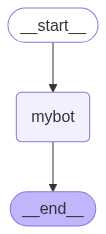

In [49]:
from IPython.display import Image, display
display(Image(app.get_graph().draw_mermaid_png()))

In [50]:
input={"messages":["hi hello how are you?"]}


In [51]:
app.invoke(input)

{'messages': [HumanMessage(content='hi hello how are you?', additional_kwargs={}, response_metadata={}, id='6e8fc0ea-15e5-45df-8ffa-9970621b8e9f'),
  AIMessage(content="<think>\n\n</think>\n\nHello! I'm just a virtual assistant, so I don't have feelings, but I'm here and ready to help you with whatever you need. How are you doing? 😊", additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 42, 'prompt_tokens': 9, 'total_tokens': 51, 'completion_time': 0.197445219, 'prompt_time': 0.000189209, 'queue_time': 0.206126909, 'total_time': 0.197634428}, 'model_name': 'deepseek-r1-distill-llama-70b', 'system_fingerprint': 'fp_76307ac09b', 'finish_reason': 'stop', 'logprobs': None}, id='run--cdbe3956-71e3-42f5-a0db-0cab44fbcf30-0', usage_metadata={'input_tokens': 9, 'output_tokens': 42, 'total_tokens': 51})]}

#### Creating custom tool

In [52]:
@tool
def search(query:str):
    """this is my custom tool for searching a weather"""
    if "delhi" in query.lower():
        return "the temp is 45 degree celsius"
    return "the temp is 25 degree celsius"

In [53]:
search.invoke("what is temperature in Charlotte?")

'the temp is 25 degree celsius'

#### Binding the tool with flow

In [54]:
search

StructuredTool(name='search', description='this is my custom tool for searching a weather', args_schema=<class 'langchain_core.utils.pydantic.search'>, func=<function search at 0x0000012FEEF27880>)

In [55]:
tools = [search]

In [56]:
tools

[StructuredTool(name='search', description='this is my custom tool for searching a weather', args_schema=<class 'langchain_core.utils.pydantic.search'>, func=<function search at 0x0000012FEEF27880>)]

In [57]:
llm_with_tool = llm.bind_tools(tools)

In [59]:
response = llm_with_tool.invoke("what is weather in delhi?")

In [61]:
response.tool_calls

[{'name': 'search',
  'args': {'query': 'weather in Delhi'},
  'id': 'jg9fy5f57',
  'type': 'tool_call'}]

In [62]:
def call_model(state: MessagesState):
    question = state['messages']
    response = llm_with_tool.invoke(question)
    return {"messages": [response]}

In [63]:
input = {"messages": ["what is the weather in delhi?"]}

In [65]:
response = call_model(input)

In [66]:
response["messages"][-1].content

''

In [67]:
response["messages"][-1].tool_calls

[{'name': 'search',
  'args': {'query': 'weather in Delhi'},
  'id': '38pd5r9eg',
  'type': 'tool_call'}]

In [68]:
def router_function(state: MessagesState):
    message = state["messages"]
    last_message = message[-1]

    if last_message.tool_calls:
        return "tools"
    return END


In [69]:
tools

[StructuredTool(name='search', description='this is my custom tool for searching a weather', args_schema=<class 'langchain_core.utils.pydantic.search'>, func=<function search at 0x0000012FEEF27880>)]

In [79]:
workflow2 = StateGraph(MessagesState)

In [80]:
workflow2.add_node("llmwithtool",call_model)

In [81]:
tool_node = ToolNode(tools)

In [82]:
workflow2.add_node("mytools", tool_node)

In [83]:
workflow2.add_edge(START, "llmwithtool")

In [84]:
workflow2.add_conditional_edges("llmwithtool",
                                router_function,
                                {"tools": "mytools",
                                END: END})

In [85]:
app2 = workflow2.compile()

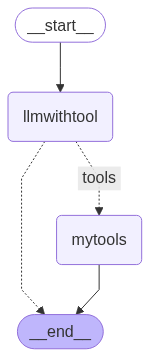

In [86]:
from IPython.display import Image, display
display(Image(app2.get_graph().draw_mermaid_png()))

In [87]:
response=app2.invoke({"messages":["what is a weather in bengraluru?"]})


In [88]:
response

{'messages': [HumanMessage(content='what is a weather in bengraluru?', additional_kwargs={}, response_metadata={}, id='37f3595e-37f9-4344-b56c-e40e1efef6ff'),
  AIMessage(content='', additional_kwargs={'reasoning_content': 'Okay, so the user is asking about the weather in Bengaluru. I need to figure out the best way to help them. They mentioned using a tool called "search" which is designed for weather searching. Let me recall the tool\'s parameters. It requires a "query" parameter, which is a string. \n\nI should format the query as "weather in Bengaluru" to get accurate results. Let me make sure the JSON structure is correct. The function name should be "search" and the arguments should have the query as "weather in Bengaluru". \n\nI think that\'s all. Let me put it together.\n', 'tool_calls': [{'id': 'vbc0sv7f6', 'function': {'arguments': '{"query":"weather in Bengaluru"}', 'name': 'search'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 152, 'prompt

In [89]:
response["messages"][-1].content


'the temp is 25 degree celsius'

In [90]:
app2.invoke({"messages":["what is a weather in delhi?"]})

{'messages': [HumanMessage(content='what is a weather in delhi?', additional_kwargs={}, response_metadata={}, id='d8d730a4-973d-4a2d-a744-65b8336d1d37'),
  AIMessage(content='', additional_kwargs={'reasoning_content': 'Okay, the user is asking about the weather in Delhi. I need to use the provided tool to find this information. The tool is called "search" and it requires a query parameter. I\'ll structure the function call with the function name as "search" and the arguments as a JSON object containing the query. The query should be "weather in Delhi" to get the relevant results.\n', 'tool_calls': [{'id': 'pjf4z1dab', 'function': {'arguments': '{"query":"weather in Delhi"}', 'name': 'search'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 103, 'prompt_tokens': 133, 'total_tokens': 236, 'completion_time': 0.453165825, 'prompt_time': 0.016388549, 'queue_time': 0.205390608, 'total_time': 0.469554374}, 'model_name': 'deepseek-r1-distill-llama-70b', 'system_

In [91]:
app2.invoke({"messages":["hi how are you?"]})

{'messages': [HumanMessage(content='hi how are you?', additional_kwargs={}, response_metadata={}, id='501ffadf-0b02-4984-b91e-5d6c54a899fb'),
  AIMessage(content="Hello! I'm just a virtual assistant, so I don't have feelings, but I'm here and ready to help you with whatever you need. How can I assist you today?", additional_kwargs={'reasoning_content': 'Alright, the user greeted me with "hi how are you?" which is a friendly opening. Since I\'m an AI, I don\'t have feelings, but I should respond politely. I want to keep the conversation going, so I\'ll ask them how I can assist them today. That should encourage them to share what they need help with.\n'}, response_metadata={'token_usage': {'completion_tokens': 111, 'prompt_tokens': 130, 'total_tokens': 241, 'completion_time': 0.499527957, 'prompt_time': 0.008394748, 'queue_time': 0.212769711, 'total_time': 0.507922705}, 'model_name': 'deepseek-r1-distill-llama-70b', 'system_fingerprint': 'fp_76307ac09b', 'finish_reason': 'stop', 'logpro